<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/GAN_Ising_Model-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [308]:
#import models & layers from TF/keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Helper libraries
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0


In [309]:
# download del dataset:
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat

#leggiamo le configurazioni ising dal file usando numpy (10k esempi oguno da 28x28 spin)
data = np.loadtxt('ising2_conf.dat')

--2020-06-01 15:36:55--  http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.1, 141.108.26.150
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19060775 (18M)
Saving to: ‘ising2_conf.dat.9’

ising2_conf.dat.9   100%[===================>]  18.18M  3.42MB/s    in 5.3s    

2020-06-01 15:37:02 (3.42 MB/s) - ‘ising2_conf.dat.9’ saved [19060775/19060775]



In [0]:
#riformattiamo i vettori in modo che abbiano la struttura di matrici di 28x28 spin
# (le configurazioni sono scritte nel file come 10000*28 righe ognuna di 28 elementi)
data = data.reshape(-1,28,28,1).astype('float32')

'''
n, m = 10, 10
fig, axs = plt.subplots(n, m, figsize=(20, 20))
for i in range(n):
  for j in range(m):
    r = np.random.randint(0, data.shape[0]-1)
    axs[i][j].imshow(data[r].reshape(28, 28))
'''
ord_sele = label < 2
cri_sele = np.logical_and(label>2, label<2.5)
dis_sele = label > 2.5

train_dataset_ord = tf.data.Dataset.from_tensor_slices(data[ord_sele])
train_dataset_ord = train_dataset_ord.shuffle(buffer_size=1024).batch(64).prefetch(32)

train_dataset_dis = tf.data.Dataset.from_tensor_slices(data[dis_sele])
train_dataset_dis = train_dataset_dis.shuffle(buffer_size=1024).batch(64).prefetch(32)

train_dataset_cri = tf.data.Dataset.from_tensor_slices(data[cri_sele])
train_dataset_cri = train_dataset_cri.shuffle(buffer_size=1024).batch(64).prefetch(32)

In [0]:
IMG_SHAPE = (28, 28, 1)

In [0]:
def get_discriminator_model():

    img_input = layers.Input(shape=IMG_SHAPE)

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1))(img_input)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    model = keras.models.Model(img_input, x, name="discriminator")
    return model

d_model_ord = get_discriminator_model()
d_model_dis = get_discriminator_model()
d_model_cri = get_discriminator_model()

In [392]:
# Generator: campiona un vettore latente e genera un immagine

# usa upsampling (Conv2DTranspose) per passare da z -> immagine
# Size of latent vector (la dimensione del vettore latente z)

latent_dim = 128

def get_generator_model():
    z = layers.Input(shape=(latent_dim,))

    x = layers.Dense(7*7*256, use_bias=False, input_shape=(128,))(z)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((7, 7, 256))(x)
    
    x = layers.Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(1, (7, 7), strides=(2, 2), padding='same', use_bias=False, activation=tf.tanh)(x)

    model = keras.models.Model(z, x, name="generator")
    return model

g_model_ord = get_generator_model()
g_model_ord.summary()
g_model_dis = get_generator_model()
g_model_cri = get_generator_model()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_84 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_159 (Dense)            (None, 12544)             1605632   
_________________________________________________________________
batch_normalization_168 (Bat (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_295 (LeakyReLU)  (None, 12544)             0         
_________________________________________________________________
reshape_78 (Reshape)         (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_135 (Conv2D (None, 7, 7, 128)         524288    
_________________________________________________________________
batch_normalization_169 (Bat (None, 7, 7, 128)         51

In [0]:
# Modello DCGAN: implementiamo un keras.Model custom
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    # funzione per la compilazione
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple): #verifica che l'input isa una python tuple (numpy tensor)
            real_images = real_images[0]

        # 1) campiona un batch di punti random nello spazio latente: z
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 2) usa il generatore per creare dai vettori latenti immagini fake: immagine = G(z)
        generated_images = self.generator(random_latent_vectors)
        #print(generated_images.shape, real_images.shape, flush=True)
        # 3) combina le immagini fake con quelle reali 
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # 4) assegna le label corrette (fae vs reale)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # 5) Trucco per diminuire la probabilità di collasso della rete (si aggiunge un po' di rumore random alle label) 
        labels += 0.2 * tf.random.uniform(tf.shape(labels))

        # 6) Training del discriminatore D
        with tf.GradientTape() as tape: #autograd
            predictions = self.discriminator(combined_images) #predizione = D(immagini)
            d_loss = self.loss_fn(labels, predictions) #calcolo loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights) #backprop
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights) #aggiornamento pesi
        )

        # 7) campiona un nuovo batch di punti dello spazio latente: z
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 8) crea un vettore di label corrispondenti a tutte immagii reali
        misleading_labels = tf.zeros((batch_size, 1))

        # 9) Training del generatore (non si devono aggiornare ovviamente i pesi del discriminatore)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors)) #predizione = D(G(z))
            g_loss = self.loss_fn(misleading_labels, predictions) #calcolo loss
        grads = tape.gradient(g_loss, self.generator.trainable_weights) #backprop
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights)) #aggiornamento pesi

        return {"d_loss": d_loss, "g_loss": g_loss}

In [0]:
# custom callback to save generated images peridoically during training
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128, norma=1.0):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.norma = norma

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * self.norma

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img2 = keras.preprocessing.image.array_to_img(img)
            img2.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))
            img = img.reshape((28*28))
            np.savetxt("generated_img_{i}_{epoch}.dat".format(i=i, epoch=epoch), img)

In [0]:
# Training della GAN

# Ottimizzatori di G e D
# learning_rate=0.0002, beta_1=0.5 are recommened
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
# Loss function
gan_loss = keras.losses.BinaryCrossentropy(from_logits=True)

# Epochs
EPOCHS = 150

# Callbacks
cbk = GANMonitor(num_img=3, latent_dim=latent_dim, norma=255)

# Istanziamento modello
gan_ord = DCGAN(discriminator=d_model_ord, generator=g_model_ord, latent_dim=latent_dim)

# Compilazione
gan_ord.compile(d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    loss_fn=gan_loss,
)

gan_dis = DCGAN(discriminator=d_model_dis, generator=g_model_dis, latent_dim=latent_dim)
gan_dis.compile(d_optimizer=discriminator_optimizer, g_optimizer=generator_optimizer,
    loss_fn=gan_loss)
gan_cri = DCGAN(discriminator=d_model_cri, generator=g_model_cri, latent_dim=latent_dim)
gan_cri.compile(d_optimizer=discriminator_optimizer, g_optimizer=generator_optimizer,
    loss_fn=gan_loss)

In [396]:
# Start training
gan_ord.fit(train_dataset_ord, epochs=EPOCHS, callbacks=[cbk], batch_size=512)
gan_cri.fit(train_dataset_cri, epochs=EPOCHS, callbacks=[cbk], batch_size=512)
gan_dis.fit(train_dataset_dis, epochs=EPOCHS, callbacks=[cbk], batch_size=512)

Epoch 1/150
63/63 [==============================] - 2s 38ms/step - d_loss: 0.5191 - g_loss: 0.7930
Epoch 2/150
63/63 [==============================] - 2s 37ms/step - d_loss: 0.4039 - g_loss: 1.3638
Epoch 3/150
63/63 [==============================] - 2s 37ms/step - d_loss: 0.5496 - g_loss: 1.2722
Epoch 4/150
63/63 [==============================] - 2s 37ms/step - d_loss: 0.5863 - g_loss: 1.1626
Epoch 5/150
63/63 [==============================] - 2s 36ms/step - d_loss: 0.5126 - g_loss: 1.4497
Epoch 6/150
63/63 [==============================] - 2s 36ms/step - d_loss: 0.3121 - g_loss: 2.3503
Epoch 7/150
63/63 [==============================] - 2s 36ms/step - d_loss: 0.3297 - g_loss: 2.2624
Epoch 8/150
63/63 [==============================] - 2s 36ms/step - d_loss: 0.3357 - g_loss: 2.2655
Epoch 9/150
63/63 [==============================] - 2s 36ms/step - d_loss: 0.3507 - g_loss: 2.1789
Epoch 10/150
63/63 [==============================] - 2s 36ms/step - d_loss: 0.4335 - g_loss: 1.7874

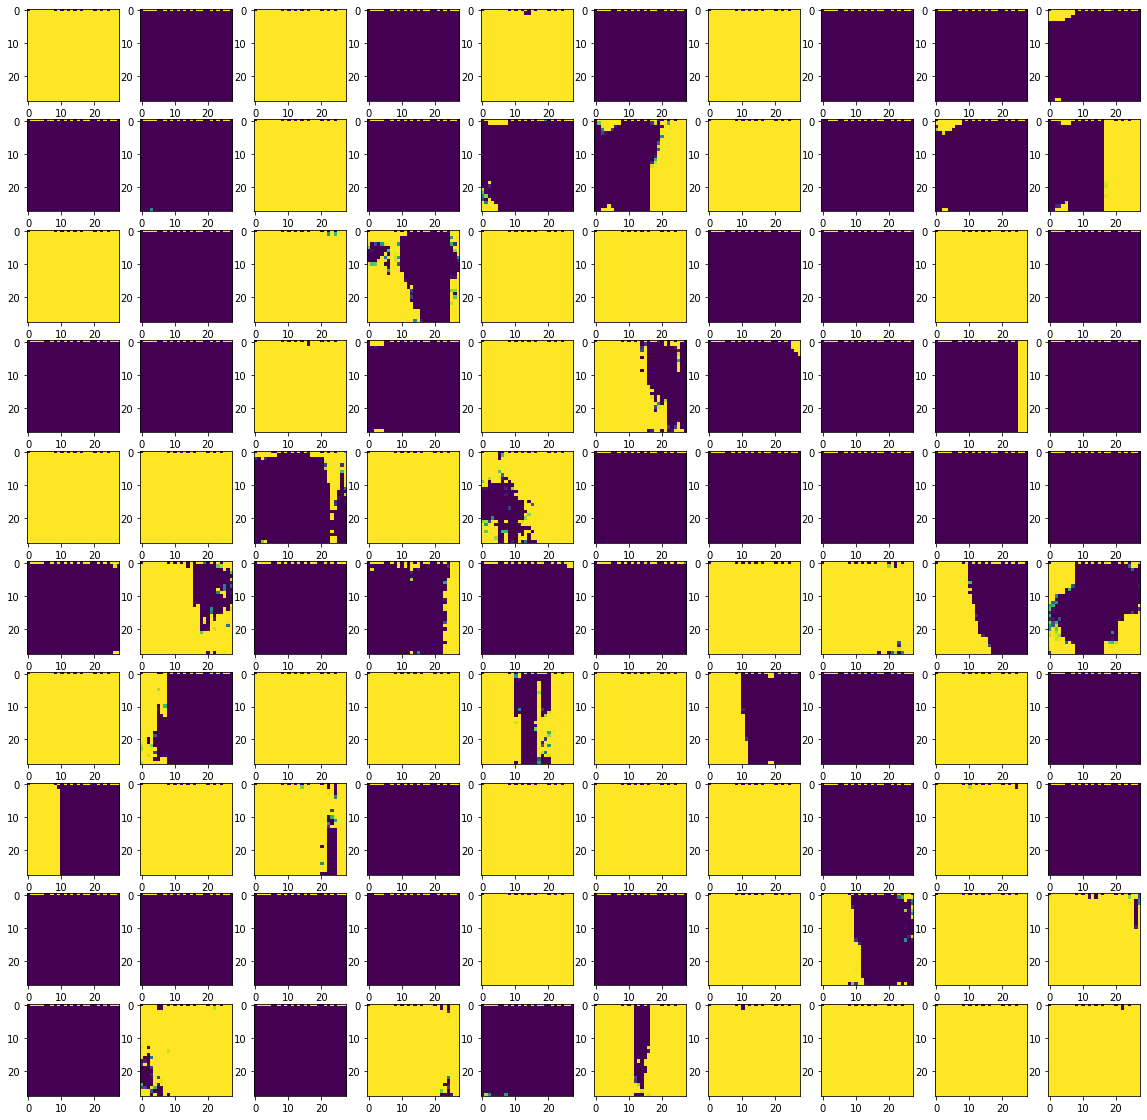

In [397]:
n, m = 10, 10
random_latent_vectors = tf.random.normal(shape=(n*m, latent_dim))
generated_images = gan_ord.generator(random_latent_vectors)

fig, axs = plt.subplots(n, m, figsize=(20, 20))
for i in range(n):
  for j in range(m):
    axs[i][j].imshow(generated_images[n*i+j].numpy().reshape((28, 28)))

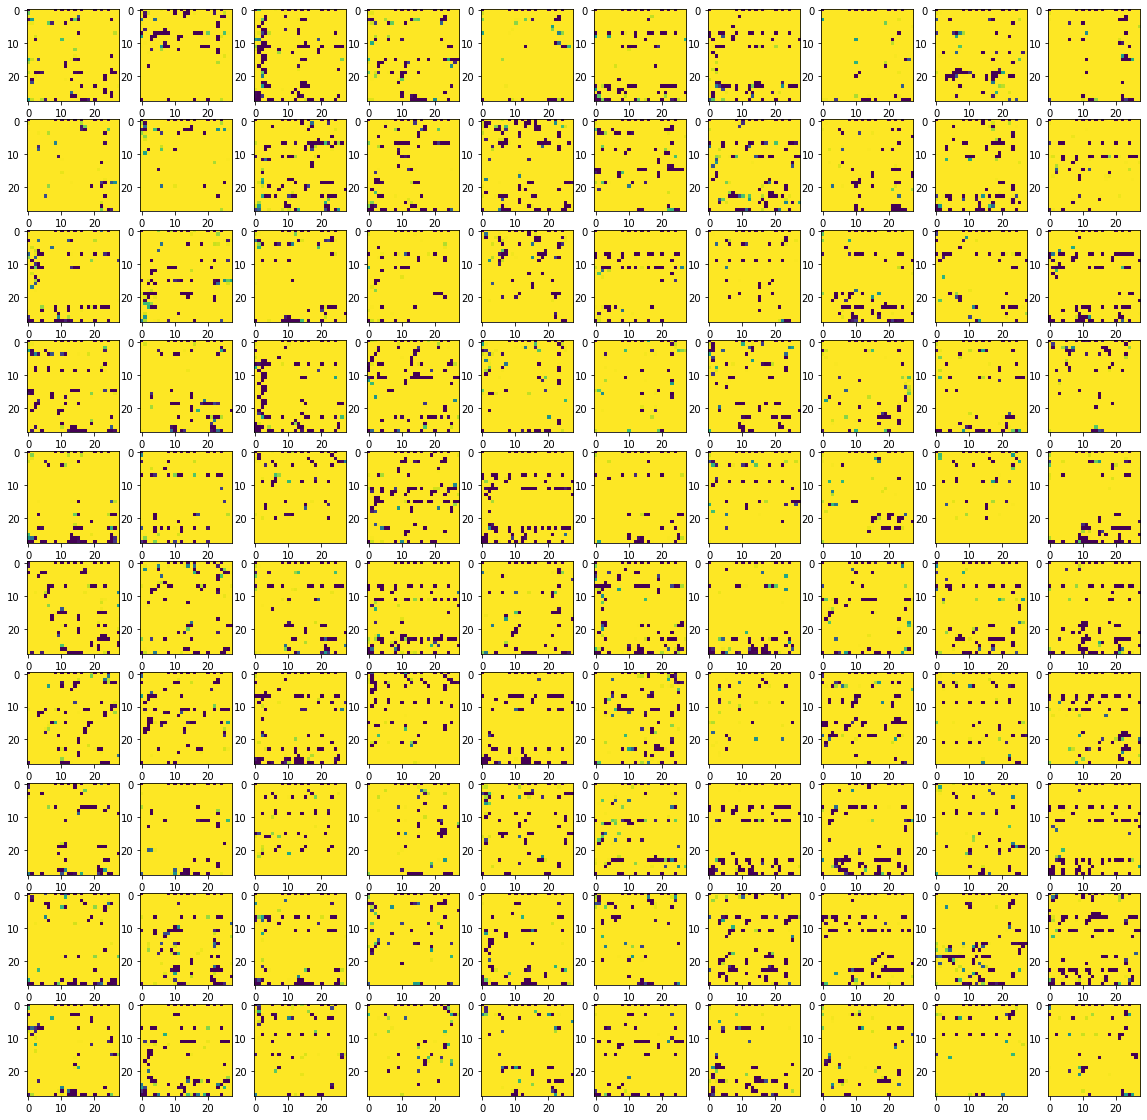

In [398]:
n, m = 10, 10
random_latent_vectors = tf.random.normal(shape=(n*m, latent_dim))
generated_images = gan_cri.generator(random_latent_vectors)

fig, axs = plt.subplots(n, m, figsize=(20, 20))
for i in range(n):
  for j in range(m):
    axs[i][j].imshow(generated_images[n*i+j].numpy().reshape((28, 28)))

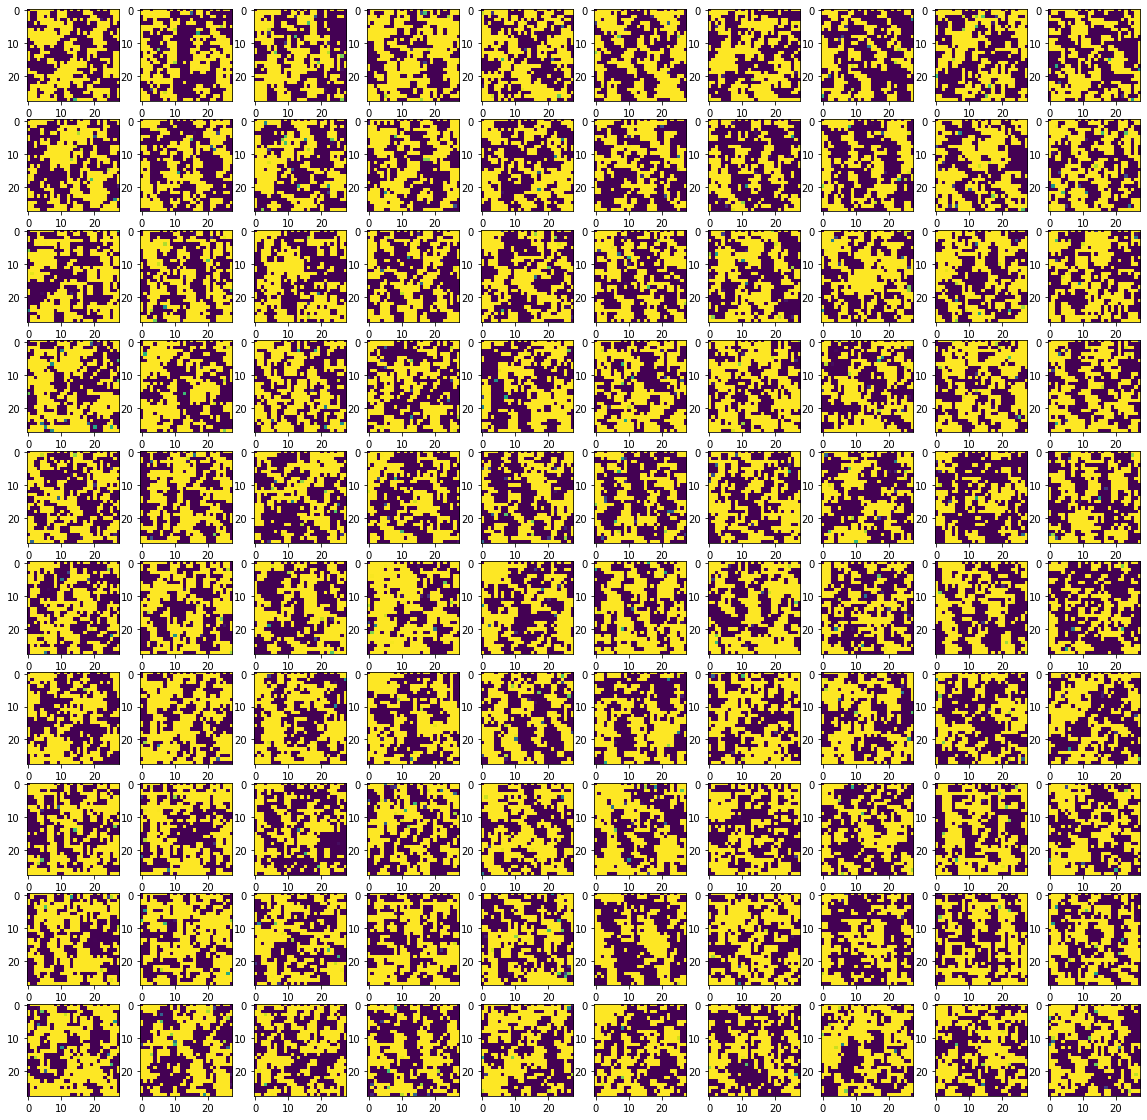

In [399]:
n, m = 10, 10
random_latent_vectors = tf.random.normal(shape=(n*m, latent_dim))
generated_images = gan_dis.generator(random_latent_vectors)

fig, axs = plt.subplots(n, m, figsize=(20, 20))
for i in range(n):
  for j in range(m):
    axs[i][j].imshow(generated_images[n*i+j].numpy().reshape((28, 28)))

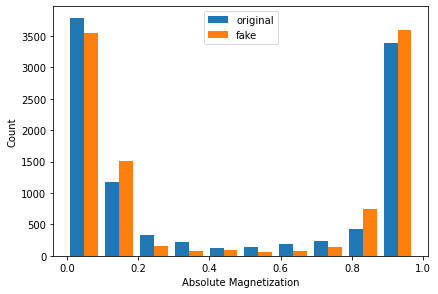

In [400]:
orig_magn = np.abs(np.mean(data, axis=(1, 2, 3)))

random_latent_vectors = tf.random.normal(shape=(len(data), latent_dim))

generated_images_ord = gan_ord.generator(random_latent_vectors[ord_sele])
generated_images_cri = gan_cri.generator(random_latent_vectors[cri_sele])
generated_images_dis = gan_dis.generator(random_latent_vectors[dis_sele])

generated_images = np.concatenate((generated_images_ord, generated_images_cri, generated_images_dis))
fake_magn = np.abs(np.mean(generated_images, axis=(1, 2, 3)))
plt.hist([orig_magn, fake_magn], label=["original", "fake"])
plt.tight_layout()
plt.legend()
plt.xlabel("Absolute Magnetization")
plt.ylabel("Count")
plt.show()
plt.close()

Dagli istogrammi si evince che la GAN ha un problema nel generare le configurazioni completamente disordinate.